# Data analysis of cloud pictures
### Matej Cief, Tomas Mizera

---

### Cloud object detection

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as plt
from matplotlib import pyplot as plpy
import cv2
from PIL import Image
from IPython.core.display import display

plpy.subplots(figsize=(30, 12))
%matplotlib inline

Data come from [this kaggle competition](https://www.kaggle.com/c/understanding_cloud_organization). They are represented as pictures with corresponding run-length encoded masks that describe specific category of cloud in the pictures.

|data| description|
|:---|:---|
|`train_images/`|directory with train images  |
|`train.csv`|masks for train images  |
|`test_images/`*|directory with test images  |
|`sample_submission.csv`*| csv showcasing sample output for kaggle competition|

Clouds are being separated into four main categories: `Fish`, `Flower`, `Gravel` and `Sugar`.

*Since we are not joining competition, we abandon `sample_submission.csv`

In [2]:
#load data
train_x = os.listdir('../data/train_images/')
train_y = pd.read_csv('../data/train.csv')
test_x = os.listdir('../data/test_images/')
categories = ['Fish', 'Flower', 'Gravel', 'Sugar']

In [3]:
data_path = '../data/train_images/'

---

### Description of data

#### `train_x` - directory with train images

Example train data:

In [4]:
showcase_pic = 'b085f55.jpg'

![example train image](../data/train_images/b085f55.jpg "example train image")

In [5]:
train_x[:5]

['203210a.jpg', 'b085f55.jpg', '5275b51.jpg', '4e6296d.jpg', '8acb403.jpg']

In [6]:
len(train_x)

5546

There are 5546 images in the dataset and all of the images are provided in `.jpg` file format

In [7]:
image = Image.open(data_path + showcase_pic)
image.size

(2100, 1400)

Each picture has 2100x1400 pixels resolution

In [8]:
from functools import reduce

In [9]:
reduce(lambda sum, file: sum + os.path.getsize(data_path + file), train_x, 0)

3713514397

Total size of train images is ~3.7GB

---

#### `train_y` mask representation 

`train_y` holds information regarding occurence of conrete cloud type in a specific image. *Each image has four rows in this DataFrame*, each row belongs to one of a types (Fish, Flower, Gravel and Sugar). 

Column **EncodedPixels** is run-length encoded value ([example, video explanation](https://www.youtube.com/watch?v=Yl50cJScObI)) that describes where is the given cloud category placed on the image. 

In [10]:
train_y.head(6)

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...
5,002be4f.jpg_Flower,1339279 519 1340679 519 1342079 519 1343479 51...


In [11]:
print_image = lambda pic: plpy.imshow(cv2.cvtColor(pic, cv2.COLOR_BGR2RGB))

In [12]:
train_y[['images']] = pd.DataFrame(train_y.apply(lambda x: x['Image_Label'].split('.')[0], axis=1))
train_y[['labels']] = pd.DataFrame(train_y.apply(lambda x: x['Image_Label'].split('.')[1].split('_')[1], axis=1))

In [13]:
train_y.shape[0]//len(categories)

5546

Number of labels is the same as the number of images in `train_x`

In [14]:
# we took these 2 functions from https://www.kaggle.com/leonshangguan/eda-cloud-data-analysis
    
"""
rle_to_mask function takes rle_string and outputs binary mask
"""
def rle_to_mask(rle_string, img):
    
    rows, cols = img.shape[0], img.shape[1]
    img = np.zeros(rows*cols, dtype=np.uint8)

    rle_numbers = [int(x) for x in rle_string.split(' ')]
    rle_pairs = np.array(rle_numbers).reshape(-1,2)

    for index, length in rle_pairs:
        index -= 1
        img[index:index+length] = 255
    img = img.reshape(cols,rows)
    img = img.T
    img = image = np.expand_dims(img, axis=2)
    
    return img


"""
ignore_background copies visible pixels from sattelite to new image with mask applied
"""
def ignore_background(img_mask, img_origin):
    assert img_mask.shape == img_mask.shape
    
    result = img_mask.copy()
    result[np.where(img_mask==255)] = img_origin[np.where(img_mask==255)]
    
    return result

In [15]:
showcase_pic_name = showcase_pic.split('.')[0]
showcase_pic_num = train_y.loc[(train_y.images == showcase_pic_name) & train_y.EncodedPixels.notnull()].index[0]

In [16]:
mask = rle_to_mask(train_y.EncodedPixels[showcase_pic_num], cv2.imread(data_path + showcase_pic))
mask[:2]

array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=uint8)

Example of mask

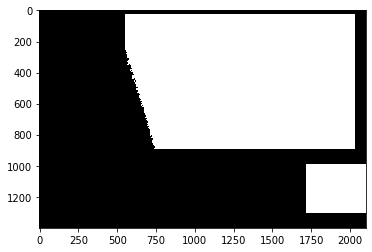

In [17]:
print_image(mask)

**How many images are there for each category**

In [18]:
train_y.head()

,Image_Label,EncodedPixels,images,labels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165,Fish
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165,Flower
2,0011165.jpg_Gravel,NaN,0011165,Gravel
3,0011165.jpg_Sugar,NaN,0011165,Sugar
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f,Fish


In [19]:
aggs = train_y.groupby(by='labels')\
    .agg(lambda x: x['EncodedPixels'].notnull().sum())[['images']]\
    .sort_values(by='images', ascending=False)
aggs

,images
labels,
Sugar,3751
Gravel,2939
Fish,2781
Flower,2365


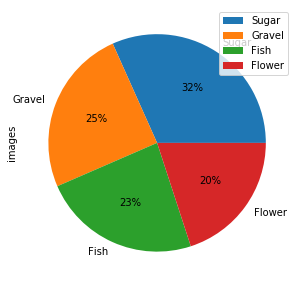

In [20]:
aggs.plot.pie(y='images', autopct='%1.0f%%', figsize=(5, 5))

Labels distribution across images

**Images cardinality - number of categories by image**

In [21]:
train_y.head()

,Image_Label,EncodedPixels,images,labels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165,Fish
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165,Flower
2,0011165.jpg_Gravel,NaN,0011165,Gravel
3,0011165.jpg_Sugar,NaN,0011165,Sugar
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f,Fish


In [22]:
aggs = train_y.groupby(by='images')\
    .agg(lambda x: x['EncodedPixels'].notnull().sum())[['labels']]\
    .reset_index()\
    .groupby(by='labels').count()
aggs

,images
labels,
1,1348
2,2372
3,1560
4,266


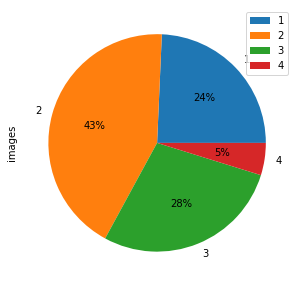

In [23]:
aggs.plot.pie(y='images', autopct='%1.0f%%', figsize=(5, 5))

43% of pictures has 2 types of clouds on them and so on.

There is a possibility that these numbers are little different than actual because there could be images including more clouds from the same category but we are not considering those in analysis

**Combine mask and image**

In [24]:
combined = ignore_background(mask, cv2.imread(data_path + showcase_pic))

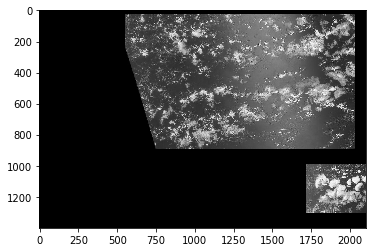

In [25]:
print_image(combined)

Image with `Flower` cloud type detected.

---

#### `test_images/` for testing purposes

In [competition](https://www.kaggle.com/c/understanding_cloud_organization) there were test data already separated for us, unfortunatelly Kaggle did not provide test_labels for test data, competitioners were supposed to generate run-length encoded file (mask of cloud categories) similar to `EncodedPixels` feature in `test_y` DataFrame.

With this in mind we decided to rather separate train data to both train and test data, because they are labeled.
However we keep test_images for predicting purposes.

In [26]:
test_x = os.listdir('../data/test_images')
len(test_x)

3698

In [27]:
reduce(lambda sum, img: sum + os.path.getsize('../data/test_images/' + img), test_x, 0)

2479939071

Test dataset consists of 3698 images with size of ~2.47GB